<h1> Using Amazon Forecast to predict web traffic using the Google WebTraffic Dataset

Here I explore the Amazon Forecast API to build a model to forecast the future website traffic based on website Id, type of traffic and the actual hits received on a particular day.
A challenge with the data is that it does not distinguish between missing data and no hits. For now, we assume that any 0s indicate no hits and not missing data, as the goal of this notebook is to showcase the use of various Forecast APIs.

<h2> Prerequisites

1) Download the data from Kaggle here: https://www.kaggle.com/c/web-traffic-time-series-forecasting/data
<br>
<br>
2) Download the dataset (train_1.csv) onto the local SageMaker notebook for exploration.
<br>
<br>
3) Create a role which allows Forecast to access s3
<br>
<br>
4) Attach the Forecast full access policy to the Sagemaker Role to ensure that your Sagemaker notebook can call Forecast APIs

<h2> Setup

Import necessary libraries and dataset.
<br>
Test boto3 version

In [1]:
import sagemaker
import boto3
import pandas as pd
import time

if boto3.__version__ != '1.9.220':
    !pip install boto3=='1.9.220'
else:
    pass


In [2]:
from time import sleep
import multiprocessing as mp

In [27]:
ACCOUNT_NUM = None # # Enter your AWS account number
REGION_NAME = 'us-east-1' #replace with your region

In [18]:
bucket = 'sagemaker-aiservices-stefan' # Modify with your s3 bucket in the specified region
prefix = 'web-forecast-data' #modify with your preferred prefix
TRAINING_SIZE = 5
role_arn = 'arn:aws:iam::{}:role/Forecastbasicrole'.format(ACCOUNT_NUM) # Create this role. role is needed to get permissions for Forecast to access S3.

In [5]:
session = boto3.Session(region_name=REGION_NAME) # make sure that the region your bucket is in is the 
#region of the session
forecast = session.client(service_name='forecast')
s3 = session.client('s3')
forecastquery = session.client(service_name='forecastquery')

<h2> PreProcessing

Before ingesting the data into S3 for importing into Forecast, lets explore the data and ensure that it conforms to the correct format required by Forecast. Additonally, we will generate some categorical features from the data to provide an example of how categorical features are handled by the models

In [6]:
# this might take sme time as we're importing the entire dataset into memory
df = pd.read_csv('train_1.csv')
df.head(10)

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0
5,5566_zh.wikipedia.org_all-access_spider,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,...,16.0,27.0,8.0,17.0,32.0,19.0,23.0,17.0,17.0,50.0
6,91Days_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,7.0,33.0,8.0,11.0,4.0,15.0,6.0,8.0,6.0
7,A'N'D_zh.wikipedia.org_all-access_spider,118.0,26.0,30.0,24.0,29.0,127.0,53.0,37.0,20.0,...,64.0,35.0,35.0,28.0,20.0,23.0,32.0,39.0,32.0,17.0
8,AKB48_zh.wikipedia.org_all-access_spider,5.0,23.0,14.0,12.0,9.0,9.0,35.0,15.0,14.0,...,34.0,105.0,72.0,36.0,33.0,30.0,36.0,38.0,31.0,97.0
9,ASCII_zh.wikipedia.org_all-access_spider,6.0,3.0,5.0,12.0,6.0,5.0,4.0,13.0,9.0,...,25.0,17.0,22.0,29.0,30.0,29.0,35.0,44.0,26.0,41.0


In [21]:
# Overview of the dataset statistics.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
2015-07-01,124323.0,1195.856567,72753.518671,0.0,13.0,109.0,524.00,20381245.0
2015-07-02,124247.0,1204.003638,74215.145424,0.0,13.0,108.0,519.00,20752194.0
2015-07-03,124519.0,1133.675969,69610.224744,0.0,12.0,105.0,504.00,19573967.0
2015-07-04,124409.0,1170.437324,72573.513699,0.0,13.0,105.0,487.00,20439645.0
2015-07-05,124404.0,1217.769300,73796.116656,0.0,14.0,113.0,540.00,20772109.0
2015-07-06,124580.0,1290.273190,80544.484681,0.0,11.0,113.0,555.00,22544669.0
2015-07-07,124399.0,1239.136754,75762.876927,0.0,13.0,115.0,551.00,21210887.0
2015-07-08,124769.0,1193.092122,68200.017009,0.0,13.0,117.0,554.00,19107911.0
2015-07-09,124819.0,1197.991772,71497.170772,0.0,14.0,115.0,549.00,19993848.0
2015-07-10,124721.0,1189.651197,72145.361308,0.0,14.0,113.0,545.00,20201821.0


Note that several columns have NaNs indicating that there is no data available on that particular day. For simplicity, let's remove all those rows and work with the leftover dataset.

In [7]:
df = df.dropna()
df.shape

(117277, 551)

Althoug we originally had 145K timeseries, we are now down to approximately 117K. This is a big reduction but it is still large enough for testing the algorithms, so we work with this dataset and split the data into train and test columns once we have done some preprocessing.

Custom script to extract categorical features from data
<br>
The dataset has two categorical features in the Page Column: type of access and type of agent.

In [8]:
def extract_categories(df):
    """ Extracts categories from the page string in each row of the dataset. Returns the original dataset with
    categorical columsn joined"""
    page_col = df.Page
    access = []
    agent = []
    for page in page_col:
        split = page.split("_")
        access.append(split[-2])
        agent.append(split[-1])
    df['Access'] = access
    df['Agent']= agent
    return df

In [9]:
extract_categories(df)

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Access,Agent
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0,all-access,spider
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0,all-access,spider
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0,all-access,spider
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0,all-access,spider
5,5566_zh.wikipedia.org_all-access_spider,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,...,8.0,17.0,32.0,19.0,23.0,17.0,17.0,50.0,all-access,spider
7,A'N'D_zh.wikipedia.org_all-access_spider,118.0,26.0,30.0,24.0,29.0,127.0,53.0,37.0,20.0,...,35.0,28.0,20.0,23.0,32.0,39.0,32.0,17.0,all-access,spider
8,AKB48_zh.wikipedia.org_all-access_spider,5.0,23.0,14.0,12.0,9.0,9.0,35.0,15.0,14.0,...,72.0,36.0,33.0,30.0,36.0,38.0,31.0,97.0,all-access,spider
9,ASCII_zh.wikipedia.org_all-access_spider,6.0,3.0,5.0,12.0,6.0,5.0,4.0,13.0,9.0,...,22.0,29.0,30.0,29.0,35.0,44.0,26.0,41.0,all-access,spider
11,Ahq_e-Sports_Club_zh.wikipedia.org_all-access_...,2.0,1.0,4.0,4.0,2.0,6.0,3.0,6.0,9.0,...,18.0,48.0,19.0,14.0,9.0,23.0,11.0,7.0,all-access,spider
12,All_your_base_are_belong_to_us_zh.wikipedia.or...,2.0,5.0,5.0,1.0,3.0,3.0,5.0,3.0,17.0,...,4.0,5.0,2.0,9.0,7.0,4.0,5.0,0.0,all-access,spider


Now we extract some information about the Categorical columns. We can feed this metadata into the Model as an additional dataset

In [10]:
import numpy as np
access_cols = np.unique(df.Access.values).tolist()
agent_cols = np.unique(df.Agent.values).tolist()
print(access_cols)
print(agent_cols)

['all-access', 'desktop', 'mobile-web']
['all-agents', 'spider']


Now we need to convert the input dataset into a dataset format and schema that can be consumed by Forecast

In [11]:
DATE_COLUMNS = df.columns.drop(['Page', 'Access', 'Agent'])

In [12]:
import datetime
timestamps = []
for string in DATE_COLUMNS:
    timestamps.append(datetime.datetime.strptime(string, '%Y-%m-%d'))

In [13]:
DATASET_FREQUENCY = "D" 
TIMESTAMP_FORMAT = "yyyy-MM-dd"

For demo purposes I will now subsample the data and take only 500 time series. One can always extract more time series to get a more accurate forecast, but this notebook is intended for illustration only.

I will then run the full code needed to generate the entire dataset and separately store it in S3. 
<br>
To sample the time series and ensure we get some examples of all the Access and Agent variables, I shuffle the dataframe

In [14]:
# Shuffle the rows in the dataframe to ensure that all 3 categorical variables are captured
df = df.sample(frac = 1)

To demonstrate model training using DeepAR, I extract 500 time series from the total dataset. This is because training on 2 years worth of daily data takes a long time in Forecast.
Let's keep track of the first 500 indexes so we can link them to the actual wikipedia page

In [15]:
index_values = list(df.index[:TRAINING_SIZE])

In [16]:
pagelists = []
for idx in index_values:
    pagelists.append(df.loc[idx]['Page'])
pagelists

['前田健_(タレント)_ja.wikipedia.org_all-access_spider',
 '辜仲諒_zh.wikipedia.org_all-access_all-agents',
 '小田かおる_ja.wikipedia.org_mobile-web_all-agents',
 '萬貞兒_zh.wikipedia.org_mobile-web_all-agents',
 '我的世界_zh.wikipedia.org_desktop_all-agents',
 'Michael_Oher_es.wikipedia.org_all-access_spider',
 'Copa_América_2007_es.wikipedia.org_all-access_all-agents',
 '鳩山エミリ_ja.wikipedia.org_desktop_all-agents',
 '田中刑事_ja.wikipedia.org_all-access_all-agents',
 '広末涼子_ja.wikipedia.org_desktop_all-agents',
 'Easter_Bunny_en.wikipedia.org_all-access_all-agents',
 'El_Clásico_en.wikipedia.org_mobile-web_all-agents',
 'Анна_(жена_Владимира_Крестителя)_ru.wikipedia.org_mobile-web_all-agents',
 '染谷将太_ja.wikipedia.org_all-access_all-agents',
 'Irma_Soriano_es.wikipedia.org_all-access_spider',
 'Aide:Liste_de_caractères_spéciaux_fr.wikipedia.org_desktop_all-agents',
 '周浩鼎_zh.wikipedia.org_desktop_all-agents',
 'Побег_(телесериал,_2005)_ru.wikipedia.org_desktop_all-agents',
 '鴨王_zh.wikipedia.org_desktop_all-agents'

Forecast will throw an error later if the Related Dataset doesn't have timestamps exceeding the Target timeseries + the Forecast Horizon. So here I pick a forecast Horizon and truncate the Target timeseries to contain only data upto the Forecast Horizon and the related series to contain all the data.

In [17]:
forecastHorizon = 30

def gen_dataset(row_num):
    dataset = []
    for j in range(len(DATE_COLUMNS)-forecastHorizon):
        dataset.append([row_num, timestamps[j], df.iloc[row_num][DATE_COLUMNS[j]]])
    return dataset

def gen_related_dataset(row_num):
    dataset = []
    for j in range(len(DATE_COLUMNS)):
        dataset.append([row_num, timestamps[j], df.iloc[row_num]['Access'], df.iloc[row_num]['Agent']])
    return dataset

In [20]:
# Create a subset of the entire dataset containing TRAINING_SIZE distinct time series.
# Re run this code to generate the entire dataset (but this will take a long time, so I'm not doing it here.
# Run this on a bigger instance with multiple cpus to speed this up

# Use Multithreading to speed things up. But if no multiprocessors available, perform single threaded processing
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())
try:
    pool = mp.Pool(mp.cpu_count())
    dataset_array = [pool.apply(gen_dataset, args = [row]) for row in range(TRAINING_SIZE)]
    dataset_array = [pool.apply(gen__related_dataset, args = [row]) for row in range(TRAINING_SIZE)]

    pool.close()
except Exception as e:
    dataset_array = [gen_dataset(row) for row in range(TRAINING_SIZE)]
    related_dataset_array = [gen_related_dataset(row) for row in range(TRAINING_SIZE)]
#for i, page in enumerate(INDEX[:10000]):
#    for j in range(len(DATE_COLUMNS)):
#        dataset_array.append([i, timestamps[j] , df.iloc[i][DATE_COLUMNS[j]]])

Number of processors:  2


In [21]:
target_series = [val for sublist in dataset_array for val in sublist]
target_series = pd.DataFrame(target_series, columns = ['item_id', 'timestamp', 'value'])
target_series.astype({'item_id': str}).dtypes

item_id              object
timestamp    datetime64[ns]
value               float64
dtype: object

In [22]:
target_series.head()

,item_id,timestamp,value
0,0,2015-07-01,7.0
1,0,2015-07-02,0.0
2,0,2015-07-03,12.0
3,0,2015-07-04,1.0
4,0,2015-07-05,16.0


In [23]:
target_series.shape

(2600, 3)

In [24]:
related_series = [val for sublist in related_dataset_array for val in sublist]
related_series = pd.DataFrame(related_series, columns = ['item_id', 'timestamp', 'Access', 'Agent'])
related_series.astype({'item_id': str})
related_series.head(3)


,item_id,timestamp,Access,Agent
0,0,2015-07-01,all-access,spider
1,0,2015-07-02,all-access,spider
2,0,2015-07-03,all-access,spider


In [25]:
dummy_series_1 = pd.get_dummies(related_series['Access'])
dummy_series_2 = pd.get_dummies(related_series['Agent'])
related_time_series = pd.concat([related_series[['item_id', 'timestamp']], dummy_series_1, dummy_series_2], axis = 1)
related_time_series =related_time_series.rename(columns={"all-access": "all_access", "mobile-web": "mobile_web", "all-agents": "all_agents"})

In [26]:
related_time_series.head()

,item_id,timestamp,all_access,desktop,mobile_web,all_agents,spider
0,0,2015-07-01,1,0,0,0,1
1,0,2015-07-02,1,0,0,0,1
2,0,2015-07-03,1,0,0,0,1
3,0,2015-07-04,1,0,0,0,1
4,0,2015-07-05,1,0,0,0,1


Upload the data to your s3 bucket

In [279]:
import os


outdir = './forecast-data'
if not os.path.exists(outdir):
    os.mkdir(outdir)

target_series.to_csv(os.path.join(outdir, 'target_time_series.csv'), index=False)
related_time_series.to_csv(os.path.join(outdir, 'related_time_series.csv'), index = False)

In [280]:
s3.upload_file(Filename="./forecast-data/target_time_series.csv", Bucket=bucket, Key="{}/{}".format(prefix, 'target_time_series.csv')
)
s3.upload_file(Filename="./forecast-data/related_time_series.csv", Bucket=bucket, Key="{}/{}".format(prefix, 'related_time_series.csv')
)

<h2> Create Dataset

Next we create the two datasets and specify the schemas needed to upload the datasets into Forecast

In [289]:
datasetName = 'webtraffic_forecast_ds'

schema ={
   "Attributes":[
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      },    
       {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"value",
         "AttributeType":"float"
      }      
   ]
}

try:
    forecast.create_dataset(
                    Domain="WEB_TRAFFIC",
                    DatasetType='TARGET_TIME_SERIES',
                    DatasetName=datasetName,
                    DataFrequency=DATASET_FREQUENCY, 
                    Schema = schema
                   )
    datasetArn = response['DatasetArn']
except Exception as e:
    datasetArn = 'arn:aws:forecast:{}:{}:dataset/{}'.format(REGION_NAME, ACCOUNT_NUM, datasetName)
    


ResourceAlreadyExistsException: An error occurred (ResourceAlreadyExistsException) when calling the CreateDataset operation: A dataset already exists with the arn: arn:aws:forecast:us-east-1:389535300735:dataset/webtraffic_forecast_ds

In [290]:
# Next creat the schema for the related time series dataset. This dataset is optional.
datasetName = 'webtraffic_forecast_related_ds'
schema ={
   "Attributes":[
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      },    
       {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"all_access",
         "AttributeType":"integer"
      },
       {
         "AttributeName":"desktop",
         "AttributeType":"integer"
      },
       {
         "AttributeName":"mobile_web",
         "AttributeType":"integer"
      },
       {
         "AttributeName":"all_agents",
         "AttributeType":"integer"
      },
       {
         "AttributeName":"spider",
         "AttributeType":"integer"
      }
   ]
}
try:
    response=forecast.create_dataset(
                    Domain="WEB_TRAFFIC",
                    DatasetType='RELATED_TIME_SERIES',
                    DatasetName=datasetName,
                    DataFrequency=DATASET_FREQUENCY, 
                    Schema = schema
                   )
    related_datasetArn = response['DatasetArn']
except Exception as e:
    related_datasetArn = 'arn:aws:forecast:{}:{}:dataset/{}'.format(REGION_NAME, ACCOUNT_NUM, datasetName)

In [292]:
# Create a Dataset Group and add these datasets to it
datasetGroupName = 'webtraffic_forecast_group'
    
try:
    create_dataset_group_response = forecast.create_dataset_group(DatasetGroupName=datasetGroupName,
                                                              Domain="WEB_TRAFFIC",
                                                              DatasetArns= [datasetArn, related_datasetArn]
                                                             )
    datasetGroupArn = create_dataset_group_response['DatasetGroupArn']
except Exception as e:
    datasetGroupArn = 'arn:aws:forecast:{}:{}:dataset-group/{}'.format(REGION_NAME, ACCOUNT_NUM, datasetGroupName)
                                                                                                              

In [293]:
# Get some metadata about the dataset group
forecast.describe_dataset_group(DatasetGroupArn=datasetGroupArn)

{'DatasetGroupName': 'webtraffic_forecast_group',
 'DatasetGroupArn': 'arn:aws:forecast:us-east-1:389535300735:dataset-group/webtraffic_forecast_group',
 'DatasetArns': ['arn:aws:forecast:us-east-1:389535300735:dataset/webtraffic_forecast_ds',
  'arn:aws:forecast:us-east-1:389535300735:dataset/webtraffic_forecast_related_ds'],
 'Domain': 'WEB_TRAFFIC',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2019, 9, 4, 16, 21, 25, 663000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2019, 9, 4, 16, 21, 25, 663000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '7516fbc9-45a6-4326-813d-15a425c94c15',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 04 Sep 2019 16:21:27 GMT',
   'x-amzn-requestid': '7516fbc9-45a6-4326-813d-15a425c94c15',
   'content-length': '431',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

<h3> Create a dataset import job

Import your data from S3 into Forecast using the create_dataset_import API

In [294]:
# For this, create a role that allows Forecast to access s3
s3DataPath = 's3://sagemaker-aiservices-stefan/web-forecast-data/target_time_series.csv'
datasetImportJobName = 'forecast_DSIMPORT_JOB_TARGET'

try:
    ds_import_job_response=forecast.create_dataset_import_job(DatasetImportJobName=datasetImportJobName,
                                                          DatasetArn=datasetArn,
                                                          DataSource= {
                                                              "S3Config" : {
                                                                 "Path":s3DataPath,
                                                                 "RoleArn": role_arn
                                                              } 
                                                          },
                                                          TimestampFormat=TIMESTAMP_FORMAT
                                                         )
    ds_import_job_arn=ds_import_job_response['DatasetImportJobArn']
except Exception as e:
    ds_import_job_arn='arn:aws:forecast:{}:{}:dataset-import-job/{}/{}'.format(REGION_NAME, ACCOUNT_NUM, datasetArn, datasetImportJobName)

ResourceAlreadyExistsException: An error occurred (ResourceAlreadyExistsException) when calling the CreateDatasetImportJob operation: A dataset import job already exists with the arn: arn:aws:forecast:us-east-1:389535300735:dataset-import-job/webtraffic_forecast_ds/forecast_DSIMPORT_JOB_TARGET

In [295]:
s3DataPath = 's3://sagemaker-aiservices-stefan/web-forecast-data/related_time_series.csv'
datasetImportJobName = 'forecast_DSIMPORT_JOB_RELATED'
try:
    ds_import_job_response=forecast.create_dataset_import_job(DatasetImportJobName=datasetImportJobName,
                                                          DatasetArn=related_datasetArn,
                                                          DataSource= {
                                                              "S3Config" : {
                                                                 "Path":s3DataPath,
                                                                 "RoleArn": role_arn
                                                              } 
                                                          },
                                                          TimestampFormat=TIMESTAMP_FORMAT
                                                         )
    ds_import_job_arn=ds_import_job_response['DatasetImportJobArn']
except Exception as e:
    ds_import_job_arn='arn:aws:forecast:{}:{}:dataset-import-job/{}/{}'.format(REGION_NAME, ACCOUNT_NUM, related_datasetArn, datasetImportJobName)

Check the status of completion for one or both of the jobs

In [284]:
# Look at the ARN for the Related time series dataset import
ds_import_job_arn=ds_import_job_response['DatasetImportJobArn']
print(ds_import_job_arn)

arn:aws:forecast:us-east-1:389535300735:dataset-import-job/webtraffic_forecast_ds/forecast_DSIMPORT_JOB_TARGET


In [285]:
#check status -- it will change from IN PROGRESS to ACTIVE once the dataset upload is completed.
while True:
    dataImportStatus = forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)['Status']
    print(dataImportStatus)
    if dataImportStatus != 'ACTIVE' and dataImportStatus != 'CREATE_FAILED':
        sleep(30)
    else:
        break


CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
ACTIVE


In [244]:
forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)

{'DatasetImportJobName': 'forecast_DSIMPORT_JOB_RELATED',
 'DatasetImportJobArn': 'arn:aws:forecast:us-east-1:389535300735:dataset-import-job/webtraffic_forecast_related_ds/forecast_DSIMPORT_JOB_RELATED',
 'DatasetArn': 'arn:aws:forecast:us-east-1:389535300735:dataset/webtraffic_forecast_related_ds',
 'TimestampFormat': 'yyyy-MM-dd',
 'DataSource': {'S3Config': {'Path': 's3://sagemaker-aiservices-stefan/web-forecast-data/related_time_series.csv',
   'RoleArn': 'arn:aws:iam::389535300735:role/Forecastbasicrole'}},
 'FieldStatistics': {'all_access': {'Count': 275000,
   'CountDistinct': 2,
   'CountNull': 0,
   'CountNan': 0,
   'Min': '0',
   'Max': '1',
   'Avg': 0.506,
   'Stddev': 0.49996490773183805},
  'all_agents': {'Count': 275000,
   'CountDistinct': 2,
   'CountNull': 0,
   'CountNan': 0,
   'Min': '0',
   'Max': '1',
   'Avg': 0.778,
   'Stddev': 0.4155919008600452},
  'date': {'Count': 275000,
   'CountDistinct': 550,
   'CountNull': 0,
   'Min': '2015-07-01T00:00:00Z',
   'M

<h2> Create Predictor

Since our information is daily, we can try to forecast the following week or month. So we set the forecast horizon to 30 to capture the next month.
<br>
<br>
Once the model is trained the print statement will change to Active

In [296]:
predictorName = 'web_traffic_forecast' + 'Deep_AR'
forecastHorizon = 30
algorithmArn = 'arn:aws:forecast:::algorithm/Deep_AR_Plus' # choose an algorithm here or set AutoML to be true.
#possible algorithmARN choices are:
#arn:aws:forecast:::algorithm/ARIMA
#arn:aws:forecast:::algorithm/ETS
#arn:aws:forecast:::algorithm/NPTS
#arn:aws:forecast:::algorithm/Prophet
# Only DeepAR supports HPO as of this notebook writing. 

In [298]:

try:
    create_predictor_response=forecast.create_predictor(PredictorName=predictorName, 
                                                  ForecastHorizon=forecastHorizon,
                                                  AlgorithmArn=algorithmArn,
                                                  PerformAutoML=False, # change to true if want to perform AutoML
                                                  PerformHPO=False, # change to true to perform HPO
                                                  EvaluationParameters= {"NumberOfBacktestWindows": 1, 
                                                                         "BackTestWindowOffset": 30}, 
                                                  InputDataConfig= {"DatasetGroupArn": datasetGroupArn},
                                                  FeaturizationConfig= {"ForecastFrequency": "D", 
                                                                        }
                                                 )
    predictorArn=create_predictor_response['PredictorArn']
except Exception as e:
    predictorArn = 'arn:aws:forecast:{}:{}:predictor/{}'.format(REGION_NAME, ACCOUNT_NUM, predictorName)

In [ ]:
while True:
    predictorStatus = forecast.describe_predictor(PredictorArn=predictorArn)['Status']
    print(predictorStatus)
    if predictorStatus != 'ACTIVE' and predictorStatus != 'CREATE_FAILED':
        sleep(30)
    else:
        break



CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS


In [302]:
forecast.describe_predictor(PredictorArn=predictorArn)

{'PredictorArn': 'arn:aws:forecast:us-east-1:389535300735:predictor/web_traffic_forecastDeep_AR',
 'PredictorName': 'web_traffic_forecastDeep_AR',
 'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
 'ForecastHorizon': 30,
 'PerformAutoML': False,
 'PerformHPO': False,
 'EvaluationParameters': {'NumberOfBacktestWindows': 1,
  'BackTestWindowOffset': 30},
 'InputDataConfig': {'DatasetGroupArn': 'arn:aws:forecast:us-east-1:389535300735:dataset-group/webtraffic_forecast_group'},
 'FeaturizationConfig': {'ForecastFrequency': 'D',
  'Featurizations': [{'AttributeName': 'value',
    'FeaturizationPipeline': [{'FeaturizationMethodName': 'filling',
      'FeaturizationMethodParameters': {'aggregation': 'sum',
       'backfill': 'zero',
       'frontfill': 'none',
       'middlefill': 'zero'}}]},
   {'AttributeName': 'all_access',
    'FeaturizationPipeline': [{'FeaturizationMethodName': 'filling',
      'FeaturizationMethodParameters': {'aggregation': 'first',
       'backfill': 'non

In [303]:
forecast.get_accuracy_metrics(PredictorArn=predictorArn)

{'PredictorEvaluationResults': [{'TestWindows': [{'EvaluationType': 'SUMMARY',
     'Metrics': {'RMSE': 16927.68876530371,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.31413592957796027},
       {'Quantile': 0.5, 'LossValue': 0.28039252282188815},
       {'Quantile': 0.1, 'LossValue': 0.10652562292905648}]}},
    {'TestWindowStart': datetime.datetime(2016, 11, 2, 0, 0, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime(2016, 12, 2, 0, 0, tzinfo=tzlocal()),
     'EvaluationType': 'COMPUTED',
     'Metrics': {'RMSE': 16927.68876530371,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.31413592957796027},
       {'Quantile': 0.5, 'LossValue': 0.28039252282188815},
       {'Quantile': 0.1, 'LossValue': 0.10652562292905648}]}}]}],
 'ResponseMetadata': {'RequestId': 'd2faeea8-b994-4442-b20f-48c572b1c47d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 04 Sep 2019 19:53:04 G

<h2> Create Forecast

In [304]:
forecastName= 'web_traffic'+'_deepar_forecast'
try:
    create_forecast_response=forecast.create_forecast(ForecastName=forecastName,
                                                  PredictorArn=predictorArn)
    forecastArn = create_forecast_response['ForecastArn']
except Exception as e:
    forecastArn='arn:aws:forecast:{}:{}:forecast/{}'.format(REGION_NAME, ACCOUNT_NUM, forecastName)

In [ ]:
while True:
    forecastStatus = forecast.describe_forecast(ForecastArn=forecastArn)['Status']
    print(forecastStatus)
    if forecastStatus != 'ACTIVE' and forecastStatus != 'CREATE_FAILED':
        sleep(30)
    else:
        break

CREATE_PENDING
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRE

<h2> Use Predictions

Use the predictions of the Forecasted results for customers in the dataset. 

In [338]:
# View the results of the forecast for a given user id.
forecastResponse = forecastquery.query_forecast(
    ForecastArn=forecastArn,
   Filters={"item_id":"0"}
)
print(forecastResponse)

{'Forecast': {'Predictions': {'p10': [{'Timestamp': '2016-12-02T00:00:00', 'Value': 4.915502548217773}, {'Timestamp': '2016-12-03T00:00:00', 'Value': 2.1925086975097656}, {'Timestamp': '2016-12-04T00:00:00', 'Value': 14.186077117919922}, {'Timestamp': '2016-12-05T00:00:00', 'Value': 10.45733642578125}, {'Timestamp': '2016-12-06T00:00:00', 'Value': 7.257536888122559}, {'Timestamp': '2016-12-07T00:00:00', 'Value': 11.97243595123291}, {'Timestamp': '2016-12-08T00:00:00', 'Value': 12.866838455200195}, {'Timestamp': '2016-12-09T00:00:00', 'Value': 5.61296272277832}, {'Timestamp': '2016-12-10T00:00:00', 'Value': 6.506840705871582}, {'Timestamp': '2016-12-11T00:00:00', 'Value': 3.1254281997680664}, {'Timestamp': '2016-12-12T00:00:00', 'Value': 8.860549926757812}, {'Timestamp': '2016-12-13T00:00:00', 'Value': 10.594517707824707}, {'Timestamp': '2016-12-14T00:00:00', 'Value': 10.055749893188477}, {'Timestamp': '2016-12-15T00:00:00', 'Value': 4.691802978515625}, {'Timestamp': '2016-12-16T00:00:0

In [320]:
# Custom code to extract time series and make plots: extract p10, p50 and p90 plots first.
import matplotlib.pyplot as plt

In [364]:
#target_series[target_series['item_id'] == 0][-50:]

In [384]:
def plot_forecast(user_index):
    """User index as string,
    returns a plot of the forecast with the prediction intervals p10, p90 with the previous 60 days for comparison"""
    mydf = target_series[target_series['item_id'] == user_index][-60:]
    
    forecastResponse = forecastquery.query_forecast(
    ForecastArn=forecastArn,
    Filters={"item_id":str(user_index)}
    )
    listvals = ['p10', 'p50', 'p90']
    for item in listvals:
        mdf = pd.DataFrame(forecastResponse['Forecast']['Predictions'][item])
        mdf.rename(columns={'Timestamp':'timestamp',
                          'Value':'value'}, inplace = True),                   
        fdf = pd.concat([mydf.drop(columns = ['item_id']), mdf], axis=0, ignore_index=True)
        plt_item = plt.plot(fdf['value'], label = "{}".format(item))
    plt.legend()
    plt.title(pagelists[user_index])
    plt.axvline(x=60, color='k', linestyle='--')
    plt.show() 
    return

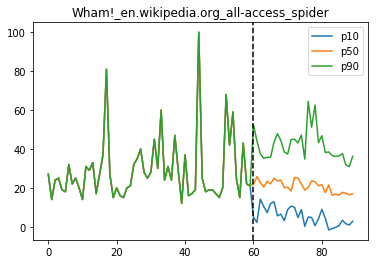

In [385]:
plot_forecast(0)

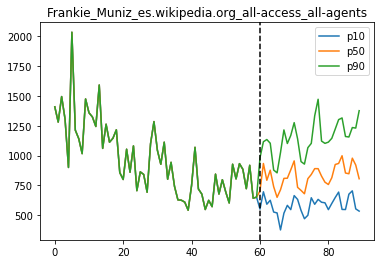

In [386]:
plot_forecast(499)

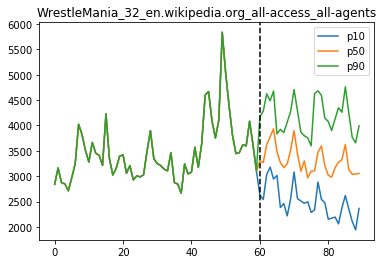

In [388]:
plot_forecast(35)

<h2> Conclusion

With the small dataset size here, we see that the deep model captures seasonal variations in some cases but not in others. Furthermore the p10-p90 bands are quite high in some cases, revealing a large spread of uncertainty, again arising from the small size of the dataset.

To continue training this model on a larger dataset, modify the training dataset size 

Delete the resources

In [389]:
# delete the dataset import jobs
forecast.delete_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)

{'ResponseMetadata': {'RequestId': '629a8efe-93c8-48a5-b0a7-e1583f76ab98',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 04 Sep 2019 22:12:25 GMT',
   'x-amzn-requestid': '629a8efe-93c8-48a5-b0a7-e1583f76ab98',
   'content-length': '0',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [390]:
# delete the dataset group
forecast.delete_dataset_group(DatasetGroupArn=datasetGroupArn)

{'ResponseMetadata': {'RequestId': '4aadec34-cb50-408c-a652-40cdeb034a97',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 04 Sep 2019 22:12:32 GMT',
   'x-amzn-requestid': '4aadec34-cb50-408c-a652-40cdeb034a97',
   'content-length': '0',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [391]:
# Delete the predictor
forecast.delete_predictor(PredictorArn=predictorArn)

{'ResponseMetadata': {'RequestId': '234057bb-61b7-4751-9424-549b8f9c8b37',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 04 Sep 2019 22:12:42 GMT',
   'x-amzn-requestid': '234057bb-61b7-4751-9424-549b8f9c8b37',
   'content-length': '0',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}